<a href="https://colab.research.google.com/github/lgiesen/forest_height/blob/main/NotebookFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
import numpy as np
import pandas as pd
import datetime, os, cv2
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape
from keras.models import Sequential, load_model
from keras.layers import Dense, BatchNormalization, Dropout, InputLayer, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras.callbacks import TensorBoard, ModelCheckpoint

## Load all the images and extract all the labels and the corresponding features

In [ ]:
!unzip gdrive/My\ Drive/DataDa2/images_train.zip

In [ ]:
!unzip gdrive/My\ Drive/DataDa2/masks_train.zip

In [22]:
size = 5 #define window size should be odd so that the label is in the middle
shape = (10, size, size) #define shape of features
labels1 = np.ones(1) #array for labels
data1 = np.ones(shape) #array for features
data1 = np.expand_dims(data1, axis=0) #expand dimension to concatenate
for j in range(20): #iterate over images in directory
  if j < 10:
    X = np.load('/content/images/image_00'+ str(j) + '.npy')
    y = np.load('/content/masks/mask_00'+ str(j) + '.npy')
    indices = np.argwhere(y > 0) #select all values with label
    indices_2d = indices[:, 1:] #extract indices
    ind_y = np.ones(2).reshape(-1,2) #array to collect indices
    for i in indices_2d: #iterate over indices
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape: #select only features with the same shape because of labels at the image border
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1] #save them temporary
        temp2 = np.expand_dims(temp, axis=0) #expand dimension to concatenate
        data1 = np.concatenate((data1, temp2), axis=0) #concatenation

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0) #concatenation of index so that they have the same order and length as the features

    ind_y = ind_y[1:] #remove first dummy values
    indices_1 = ind_y[:, 0].astype(int)
    indices_2 = ind_y[:, 1].astype(int)
    data_y = y[0, indices_1, indices_2] #extract labels
    labels1 = np.concatenate((labels1, data_y), axis = 0) #concatenate labels

  if j >= 10:
    X = np.load('/content/images/image_0'+ str(j) + '.npy')
    y = np.load('/content/masks/mask_0'+ str(j) + '.npy')
    indices = np.argwhere(y > 0)
    indices_2d = indices[:, 1:]
    ind_y = np.ones(2).reshape(-1,2)
    for i in indices_2d:
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape:
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1]
        temp2 = np.expand_dims(temp, axis=0)
        data1 = np.concatenate((data1, temp2), axis=0)

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0)

    ind_y = ind_y[1:]
    indices_1 = ind_y[:, 0].astype(int)
    indices_2 = ind_y[:, 1].astype(int)
    data_y = y[0, indices_1, indices_2]
    labels1 = np.concatenate((labels1, data_y), axis = 0)

data1 = data1[1:] #remove first dummy values
labels1 = labels1[1:] #remove first dummy values

In [ ]:
!unzip gdrive/My\ Drive/DataDa22/images_02.zip #second part of the data

In [ ]:
!unzip gdrive/My\ Drive/DataDa22/masks_02.zip

In [25]:
shape = (10, size, size)
labels2 = np.ones(1)
data2 = np.ones(shape)
data2 = np.expand_dims(data2, axis=0)
for j in range(20):
  if j < 10:
    X = np.load('/content/images/image_00'+ str(j) + '.npy')
    y = np.load('/content/masks/mask_00'+ str(j) + '.npy')
    indices = np.argwhere(y > 0)
    indices_2d = indices[:, 1:]
    ind_y = np.ones(2).reshape(-1,2)
    for i in indices_2d:
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape:
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1]
        temp2 = np.expand_dims(temp, axis=0)
        data2 = np.concatenate((data2, temp2), axis=0)

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0)

    ind_y = ind_y[1:]
    indices_1 = ind_y[:, 0].astype(int)
    indices_2 = ind_y[:, 1].astype(int)
    data_y = y[0, indices_1, indices_2]
    labels2 = np.concatenate((labels2, data_y), axis = 0)

  if j >= 10:
    X = np.load('/content/images/image_0'+ str(j) + '.npy')
    y = np.load('/content/masks/mask_0'+ str(j) + '.npy')
    indices = np.argwhere(y > 0)
    indices_2d = indices[:, 1:]
    ind_y = np.ones(2).reshape(-1,2)
    for i in indices_2d:
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape:
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1]
        temp2 = np.expand_dims(temp, axis=0)
        data2 = np.concatenate((data2, temp2), axis=0)

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0)

    ind_y = ind_y[1:]
    indices_1 = ind_y[:, 0].astype(int)
    indices_2 = ind_y[:, 1].astype(int)
    data_y = y[0, indices_1, indices_2]
    labels2 = np.concatenate((labels2, data_y), axis = 0)

data2 = data2[1:]
labels2 = labels2[1:]

In [26]:
features = np.concatenate((data1, data2), axis = 0) #concatenate both parts
features[features > 2000] = 2000
labels = np.concatenate((labels1, labels2), axis = 0)

## Optional: Create equally distributed data set

In [ ]:
sample_size = 800
#features = np.mean(features, axis=(2, 3)) # patch mean of size * size features

num = (list(range(3, 37, 3))) #create list from 3 to 36 step 3
shape = (10, 5, 5)
data_bal = np.ones(shape) #create array to fill with features
data_bal = np.expand_dims(data_bal, axis=0) #expand one dimension to concatenate
data_lab = np.ones(1) #create array to fill labels
for i in num:
  indices = np.where((labels > i-3) & (labels <= i)) #select indcies from every 3 meter interval until 36
  sampled_indices = np.random.choice(indices[0].flatten(), size=sample_size, replace=False) #random sample of each interval
  tempx = features[sampled_indices]
  tempy = labels[sampled_indices]
  data_bal = np.concatenate((data_bal, tempx), axis=0)
  data_lab = np.concatenate((data_lab, tempy), axis=0)

indices = np.where((labels > 36)) #add the values > 36 m, they are so few no sample needed
sampled_indices = indices[0].flatten()
tempx = features[sampled_indices]
tempy = labels[sampled_indices]
data_bal = np.concatenate((data_bal[1:], tempx), axis=0)
data_lab = np.concatenate((data_lab[1:], tempy), axis=0)

## Neural Network

### Training and evaluation

In [27]:
features_mean = np.mean(features, axis=(2, 3)) # patch mean of size * size features
Xtrain, Xtest, ytrain, ytest = train_test_split(features_mean, labels , test_size = 0.3, random_state=3)

In [ ]:
%load_ext tensorboard

In [ ]:
modelNn = Sequential() #build neural network
modelNn.add(Dense(128, input_shape=(10,), kernel_initializer='normal', activation='relu'))
modelNn.add(Dense(256, kernel_initializer='normal', activation='relu'))
modelNn.add(Dense(256, kernel_initializer='normal', activation='relu'))
modelNn.add(Dense(128, kernel_initializer='normal', activation='relu'))
modelNn.add(Dropout(0.4))
modelNn.add(Dense(1, kernel_initializer='normal', activation='linear'))

modelNn.summary()

In [ ]:
modelNn.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_percentage_error']) #compile model

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) #log directory tensorboard
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model_save = ModelCheckpoint("/content/gdrive/MyDrive/NNmodels/best_model3.hdf52", save_best_only = True) #directory best model

modelNn.fit(Xtrain, ytrain, epochs = 100, validation_data=(Xtest, ytest), callbacks=[tensorboard_callback, model_save]) #fit model

In [37]:
bmodel = load_model('/content/gdrive/MyDrive/NNmodels/best_model3.hdf52') #load best model

ypred_nn = bmodel.predict(Xtest)

mse_nn = mse(ytest, ypred_nn)

rmse_nn = mse_nn ** (1/2)

mae_nn = mae(ytest, ypred_nn)

mape_nn = mape(ytest, ypred_nn)

print(mape_nn)

print(mae_nn)

print(rmse_nn)

362/362 [==============================] - 1s 2ms/step
0.49005475065971976
4.430073310357477
7.320163610567323


In [ ]:
%tensorboard --logdir logs

In [ ]:
mean_nn = np.mean(ypred_nn[:]) #calculate mean
quantiles_nn = np.percentile(ypred_nn[:], [1, 25, 50, 75, 99]) #calculate quantiles 0.01, 0.25, 0.5, 0.75, 0.99

mean_labels = np.mean(labels[:])
quantiles_labels = np.percentile(labels[:], [1, 25, 50, 75, 99])

print(mean_nn)
print(quantiles_nn)
print(np.sort(ypred_nn.flatten())[:10]) #print the 10 lowest predictions
print(np.sort(ypred_nn.flatten())[-10:][::-1]) #print the 10 highest predictions

print(mean_labels)
print(quantiles_labels)
print(np.sort(labels.flatten())[:10])
print(np.sort(labels.flatten())[-10:][::-1])

### Prediction of test image neural network

In [ ]:
Xs = np.load('/content/gdrive/MyDrive/TestData/private_test_image_reduced.npy') #load test image
patch_size = 1024 #define patch size
ind = 0 #index for saved oatch images

for i in range(4):
  for j in range(4):
    temp = Xs[:,i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
    np.save('/content/gdrive/MyDrive/TestPatches/patch_'+ str(ind) + '.npy', temp)
    ind = ind + 1


In [ ]:
folder_path = '/content/gdrive/MyDrive/TestPatches/'  #folder path
nnmodel = load_model('/content/gdrive/MyDrive/NNmodels/best_model3.hdf52')
ind = 0

# Iterate over the files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
      X = np.load(file_path) #load patch
      X[X > 2000] = 2000 #ceeling
      Xr = X.reshape(10,-1).transpose() #transpose patch
      nnpred = nnmodel.predict(Xr) #predict labels
      nnpredr = nnpred.transpose().reshape(1,1024,1024) #reshape patch to image size
      np.save('/content/gdrive/MyDrive/MaskNN/mask_'+ str(ind) + '.npy', nnpredr) #save patch
      ind = ind + 1
      print(np.percentile(nnpred[:], [1, 25, 50, 75, 99]))
      print(np.sort(nnpred.flatten())[:10])
      print(np.sort(nnpred.flatten())[-10:][::-1])

In [ ]:
folder_path = '/content/gdrive/MyDrive/MaskNN/'  #folder path
img_list = []

# Iterate over the files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        # Load the data from the file
        data = np.load(file_path)
        # Append the data to the list
        img_list.append(data)
# Concatenate the patches along the columns (horizontal axis)
im1 = np.concatenate((img_list[0], img_list[1], img_list[2], img_list[3]), axis=2)
im2 = np.concatenate((img_list[4], img_list[5], img_list[6], img_list[7]), axis=2)
im3= np.concatenate((img_list[8], img_list[9], img_list[10], img_list[11]), axis=2)
im4 = np.concatenate((img_list[12], img_list[13], img_list[14], img_list[15]), axis=2)

# Concatenate the rows along the vertical axis to rebuild the original image
original_image = np.concatenate((im1, im2, im3, im4), axis=1)
np.save('/content/gdrive/MyDrive/FinalPredictions/mask_private_nn.npy', original_image)

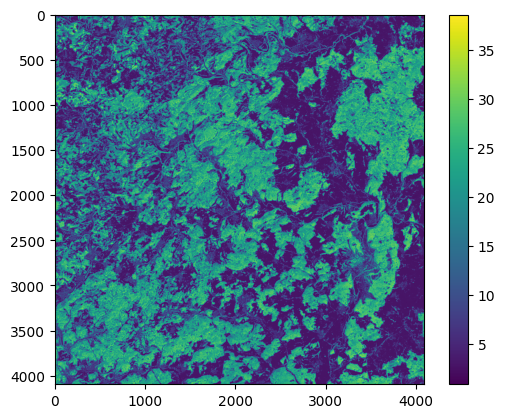

In [ ]:
tree_height_2d = original_image[0]

# Plot the tree height data
plt.imshow(tree_height_2d, cmap='viridis')

# Add colorbar for reference
plt.colorbar()

# Display the plot
plt.show()

# Convolutional neural network

### Training and evaluation

In [39]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels , test_size = 0.3, random_state=3) #create train, test set

In [ ]:
%load_ext tensorboard

In [36]:
modelCnn = Sequential() #bulid cnn
modelCnn.add(InputLayer(input_shape = (10, 5, 5)))
modelCnn.add(Conv2D(filters=128, kernel_size= (3,3), strides=  1 , padding = "same", activation='relu' ))
modelCnn.add(Conv2D(filters=256, kernel_size= (3,3), strides=  1 , padding = "valid", activation='relu' ))
modelCnn.add(MaxPool2D(pool_size = (2,2)))
modelCnn.add(Flatten())
modelCnn.add(Dense(512, activation='relu'))
modelCnn.add(Dense(128, activation='relu'))
modelCnn.add(Dropout(0.4))
modelCnn.add(Dense(1, activation='linear'))

modelCnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 5, 128)        5888      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 3, 256)         295168    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 1, 256)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                        

In [ ]:
modelCnn.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_percentage_error']) #compile cnn
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model_save = ModelCheckpoint("/content/gdrive/MyDrive/NNmodels/best_modelCnnPred.hdf5", save_best_only = True) #save best model

modelCnn.fit(Xtrain, ytrain, epochs = 100, validation_data=(Xtest, ytest), callbacks=[tensorboard_callback, model_save]) #train cnn

In [40]:
bmodel = load_model('/content/gdrive/MyDrive/NNmodels/best_modelCnnPred.hdf5')
ypred_cnn = bmodel.predict(Xtest) #predict best model


mse_cnn = mse(ytest, ypred_cnn) #calculate metrics
rmse_cnn = mse_cnn ** (1/2)
mae_cnn = mae(ytest, ypred_cnn)
mape_cnn = mape(ytest, ypred_cnn)

print(mape_cnn)
print(mae_cnn)
print(rmse_cnn)

362/362 [==============================] - 10s 27ms/step
0.4730710697381019
4.145201797314169
6.899690022895448


In [ ]:
%tensorboard --logdir logs

In [ ]:
mean_cnn = np.mean(ypred_cnn[:]) #calculate mean
quantiles_cnn = np.percentile(ypred_cnn[:], [1, 25, 50, 75, 99]) #calculate quantiles 0.01, 0.25, 0.5, 0.75, 0.99
mean_labels = np.mean(labels[:])
quantiles_labels = np.percentile(labels[:], [1, 25, 50, 75, 99])

print(mean_cnn)
print(quantiles_cnn)
print(np.sort(ypred_cnn.flatten())[:10]) #print the 10 lowest predictions
print(np.sort(ypred_cnn.flatten())[-10:][::-1]) #print the 10 highest predictions

print(mean_labels)
print(quantiles_labels)
print(np.sort(labels.flatten())[:10])
print(np.sort(labels.flatten())[-10:][::-1])

### Prediction of test image convolutional neural network

In [ ]:
folder_path = '/content/gdrive/MyDrive/TestPatches/'  #folder path
cnnmodel = load_model('/content/gdrive/MyDrive/NNmodels/best_modelCnnPred.hdf5')
ind = 0

# Iterate over the files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
      X = np.load(file_path)

      pad_width = ((0, 0), (2, 2), (2, 2))  # Pad width of 2 on the second and third axes to (10, 1028, 1028) to get output of shape (10, 1024, 1024) with a window of size 5
      X = np.pad(X, pad_width, mode='constant', constant_values=0)

      height, width = X.shape[1], X.shape[2] #get height an width of the image
      window_size = 5
      shape = (10, window_size, window_size)
      datat = np.ones(shape) #array for features
      datat = np.expand_dims(datat, axis=0)

      for w in range(width - window_size + 1): # select the first row (10, 5, 5) patches
        sample = X[:, 0:window_size, w:w+window_size]
        sample2 = np.expand_dims(sample, axis=0)
        datat = np.concatenate((datat, sample2), axis=0)

      datat = datat[1:,:,:,:] #remove the first artificial patch

      for h in range(height - window_size): # iterate over the rows
        shape = (10, 1, window_size)
        datat2 = np.ones(shape) #array for the values of one row
        datat2 = np.expand_dims(datat2, axis=0)
        for w in range(width - window_size  + 1): # iterate over the columns
          sample = X[:, h+window_size, w:w+window_size]
          sample = np.expand_dims(sample, axis=1)
          sample = np.expand_dims(sample, axis=0)
          datat2 = np.concatenate((datat2, sample), axis=0) #collect values from one row

        datat4 = np.concatenate((datat[(width-window_size+1)*h:,:,1:,:], datat2[1:,:,:,:]), axis=2) #remove the first column from the previous row patches and add a new row below
        datat = np.concatenate((datat, datat4), axis=0) #stack the patches

      datat[datat > 2000] = 2000 #ceeling
      pred = cnnmodel.predict(datat) #predict labels
      img = pred.transpose().reshape(1,1024,1024) #reshape image to original size
      np.save('/content/gdrive/MyDrive/MaskCNN/mask_'+ str(ind) + '.npy', img)
      ind = ind + 1
      print(img.shape) #metrics to control the prediction process for every patch
      print(np.percentile(pred[:], [1, 25, 50, 75, 99]))
      print(np.sort(pred.flatten())[:10])
      print(np.sort(pred.flatten())[-10:][::-1])

In [ ]:
folder_path = '/content/gdrive/MyDrive/MaskCNN/'  #folder path
img_list = []

# Iterate over the files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        # Load the data from the file
        data = np.load(file_path)
        # Append the data to the list
        img_list.append(data)
# Concatenate the patches along the columns (horizontal axis)
im1 = np.concatenate((img_list[0], img_list[1], img_list[2], img_list[3]), axis=2)
im2 = np.concatenate((img_list[4], img_list[5], img_list[6], img_list[7]), axis=2)
im3= np.concatenate((img_list[8], img_list[9], img_list[10], img_list[11]), axis=2)
im4 = np.concatenate((img_list[12], img_list[13], img_list[14], img_list[15]), axis=2)

# Concatenate the rows along the vertical axis to rebuild the original image
original_image = np.concatenate((im1, im2, im3, im4), axis=1)
np.save('/content/gdrive/MyDrive/FinalPredictions/mask_private_cnn.npy', original_image)

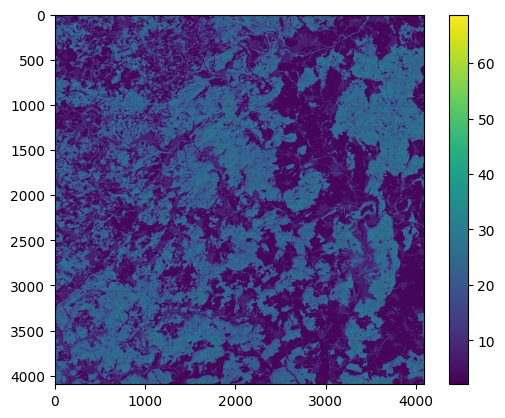

In [ ]:
tree_height_2d = original_image[0]

# Plot the tree height data
plt.imshow(tree_height_2d, cmap='viridis')

# Add colorbar for reference
plt.colorbar()

# Display the plot
plt.show()

In [ ]:
print(np.percentile(original_image[:], [1, 25, 50, 75, 99])) #calculate quantiles 0.01, 0.25, 0.5, 0.75, 0.99

print(np.sort(original_image.flatten())[:10]) #print the 10 lowest predictions
print(np.sort(original_image.flatten())[-10:][::-1]) #print the 10 highest predictions

[ 2.8541925   2.92888093 12.29226542 23.57959366 30.57535   ]
[2.1069705 2.1151602 2.117415  2.1205459 2.1237712 2.1339014 2.1387982
 2.1457536 2.1482716 2.1490788]
[68.713    63.57204  59.222446 58.00055  57.905674 55.202805 54.94809
 54.020313 52.08589  51.968132]


In [ ]:
for i in range Xs.shape[0]:
  Xs[i] = (Xs[i] - np.mean(Xs[i])) / np.std(Xs[i])** (1/2) #normalize features

In [33]:
dtr = GradientBoostingRegressor(n_estimators = 100, max_depth= 1, random_state=1)

dtr.fit(Xtrain, ytrain)

ypred_dtr = dtr.predict(Xtest)

mse_dtr = mse(ytest, ypred_dtr)

rmse_dtr = mse_dtr ** (1/2)

mae_dtr = mae(ytest, ypred_dtr)

mape_dtr = mape(ytest, ypred_dtr)

print(mape_dtr)
print(mae_dtr)
print(rmse_dtr)

0.7045404257132958
4.885167658458536
7.185917440319357


In [34]:
rf = RandomForestRegressor(n_estimators = 400, min_samples_leaf= 0.04, random_state=1)

rf.fit(Xtrain, ytrain)

ypred_rf = rf.predict(Xtest)

mse_rf = mse(ytest, ypred_rf)

rmse_rf = mse_rf ** (1/2)

mae_rf = mae(ytest, ypred_rf)

mape_rf = mape(ytest, ypred_rf)

print(mape_rf)

print(mae_rf)

print(rmse_rf)

0.7271810385044871
4.959112148911681
7.338334355732916


In [35]:
mean_bt = np.mean(ypred_dtr[:])
mean_rf = np.mean(ypred_rf[:])
mean_labels = np.mean(labels[:])

quantiles_bt = np.percentile(ypred_dtr[:], [1, 25, 50, 75, 99])
quantiles_rf = np.percentile(ypred_rf[:], [1, 25, 50, 75, 99])
quantiles_labels = np.percentile(labels[:], [1, 25, 50, 75, 99])

print(mean_bt)
print(quantiles_bt)
print(mean_rf)
print(quantiles_rf)
print(mean_labels)
print(quantiles_labels)

11.881136439193924
[ 3.76581872  4.62934528  7.29608195 20.60469315 27.11061745]
11.896737760384795
[ 3.30652229  4.59394416  7.80112008 19.93720827 26.23900478]
11.88373569284665
[ 2.3900001   2.8599999   5.6500001  20.79999924 39.44700012]
